# TransE Model Training Pipeline

This notebook implements and trains the TransE (Translating Embeddings) model for citation link prediction. The TransE model learns embeddings such that for each citation relationship (source_paper, target_paper), the embedding of source_paper + relation ≈ embedding of target_paper.

## TransE Model Overview

**Core Principle**: For a citation relationship (paper_A cites paper_B), we want:
```
embedding(paper_A) + embedding("CITES") ≈ embedding(paper_B)
```

**Training Objective**: Minimize the distance for positive citations while maximizing it for negative (non-existent) citations using margin ranking loss.

## Training Pipeline

1. **Data Preparation**: Load citation network and create train/test splits
2. **Negative Sampling**: Generate negative examples for contrastive learning
3. **Model Initialization**: Create TransE model with configurable embeddings
4. **Training Loop**: Optimize with margin ranking loss and Adam optimizer
5. **Monitoring**: Track loss convergence and embedding quality
6. **Model Persistence**: Save trained model and metadata

## Requirements

- PyTorch for deep learning framework
- Academic Citation Platform data from previous exploration
- Sufficient memory for embedding matrices (num_papers × embedding_dim)
- Optional: GPU for faster training on large networks

In [1]:
# Import required libraries
import sys
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project components
from src.services.ml_service import TransEModel, get_ml_service
from src.services.analytics_service import get_analytics_service
from src.database.connection import Neo4jConnection
from src.data.unified_database import UnifiedDatabaseManager

# Set up plotting style
plt.style.use('default')
sns.set_palette("viridis")

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

print("✅ Libraries imported successfully")
print(f"🚂 Model training pipeline ready at: {datetime.now()}")

🔧 Using device: cpu
✅ Libraries imported successfully
🚂 Model training pipeline ready at: 2025-08-31 20:54:55.924372


## Step 1: Load Data from Previous Analysis

We'll load the comprehensive data from our previous exploration notebook to ensure consistency and leverage the insights we've already gathered.

In [2]:
from src.data.unified_database import QueryLibrary

# Load exploration data from previous notebook
print("📚 Loading data from comprehensive exploration...")

try:
    # Try to load exploration data first
    exploration_data_path = '/Users/bhs/PROJECTS/academic-citation-platform/outputs/exploration_data.pkl'
    with open(exploration_data_path, 'rb') as f:
        exploration_data = pickle.load(f)
    
    print("✅ Loaded exploration data from previous analysis")
    
    # Extract data for training
    papers_data = exploration_data['papers_data']
    citation_data = exploration_data['citation_data']
    entity_mapping = exploration_data['entity_mapping']
    reverse_mapping = exploration_data['reverse_mapping']
    num_entities = exploration_data['num_entities']
    network_results = exploration_data.get('network_results', {})
    
    print(f"   Papers: {len(papers_data):,}")
    print(f"   Citations: {len(citation_data):,}")
    print(f"   Entity mapping: {num_entities:,} entities")
    
except FileNotFoundError:
    print("⚠️ Exploration data not found. Loading fresh data...")
    
    # Fallback to loading fresh data
    db_connection = Neo4jConnection()
    db = UnifiedDatabaseManager()
    
    if not db_connection.test_connection():
        raise ConnectionError("❌ Failed to connect to Neo4j database")
    
    # Get papers and citations from database
    papers_data = db.query(QueryLibrary.GET_PAPERS_FOR_TRAINING)
    citation_data = db.query(QueryLibrary.GET_CITATION_EDGES)
    
    papers_data = papers_data.to_dict('records')
    citation_data = citation_data.to_dict('records')
    
    # Create mappings
    entity_mapping = {paper['paper_id']: idx for idx, paper in enumerate(papers_data)}
    reverse_mapping = {idx: paper['paper_id'] for idx, paper in enumerate(papers_data)}
    num_entities = len(papers_data)
    network_results = {}
    
    print("✅ Fresh data loaded successfully")
    print(f"   Papers: {len(papers_data):,}")
    print(f"   Citations: {len(citation_data):,}")
    
    # Close database connection
    db_connection.close()

print(f"\n📊 Dataset Overview:")
print(f"   Entity vocabulary size: {num_entities:,}")
print(f"   Citation relationships: {len(citation_data):,}")
print(f"   Average citations per paper: {len(citation_data) / num_entities:.2f}")
print(f"   Network density: {len(citation_data) / (num_entities * (num_entities - 1)):.6f}")

print("\n🎯 Data ready for model training pipeline!")

📚 Loading data from comprehensive exploration...
⚠️ Exploration data not found. Loading fresh data...


TransE model not found at models/transe_citation_model.pt


✅ Fresh data loaded successfully
   Papers: 12,595
   Citations: 18,912

📊 Dataset Overview:
   Entity vocabulary size: 12,595
   Citation relationships: 18,912
   Average citations per paper: 1.50
   Network density: 0.000119

🎯 Data ready for model training pipeline!


## Step 2: Prepare Training Data with Train/Test Split

We'll create proper train/test splits with negative sampling to generate a balanced dataset for training our TransE model. This is crucial for learning meaningful embeddings.

In [4]:
# Configure data preparation parameters
DATA_CONFIG = {
    'test_size': 0.2,           # 80/20 train/test split
    'negative_ratio': 1,        # 1:1 ratio of negative to positive samples
    'random_state': 42,         # For reproducible results
    'min_degree': 1             # Minimum degree for papers to include
}

print("🔧 Data Preparation Configuration:")
for key, value in DATA_CONFIG.items():
    print(f"   {key}: {value}")

print(f"\n🔄 Preparing training data with train/test split...")

# Convert citation data to edge format
edges = []
for citation in citation_data:
    # Handle different citation data formats
    if 'source_idx' in citation and 'target_idx' in citation:
        source_idx = citation['source_idx']
        target_idx = citation['target_idx']
    else:
        source_paper_id = citation.get('source_id')
        target_paper_id = citation.get('target_id')
        
        if source_paper_id in entity_mapping and target_paper_id in entity_mapping:
            source_idx = entity_mapping[source_paper_id]
            target_idx = entity_mapping[target_paper_id]
        else:
            continue  # Skip if papers not in mapping
    
    edges.append([source_idx, target_idx])

# Convert to tensor
positive_edges = torch.tensor(edges, dtype=torch.long)

print(f"✅ Processed {len(positive_edges):,} positive citation edges")

# Create train/test split
train_pos_edges, test_pos_edges = train_test_split(
    positive_edges,
    test_size=DATA_CONFIG['test_size'],
    random_state=DATA_CONFIG['random_state']
)

print(f"📊 Train/Test Split:")
print(f"   Training positive edges: {len(train_pos_edges):,}")
print(f"   Test positive edges: {len(test_pos_edges):,}")

# Generate negative samples for training
print(f"\n🎲 Generating negative samples (ratio 1:{DATA_CONFIG['negative_ratio']})...")

def generate_negative_samples(positive_edges, num_entities, num_negative, random_state=42):
    """
    Generate negative samples by randomly sampling non-existent edges.
    Ensures no overlap with positive edges for valid negative examples.
    """
    np.random.seed(random_state)
    
    # Create set of positive edges for fast lookup
    positive_set = set(map(tuple, positive_edges.numpy()))
    
    negative_edges = []
    attempts = 0
    max_attempts = num_negative * 10  # Avoid infinite loops
    
    print(f"   Generating {num_negative:,} negative samples...")
    
    with tqdm(total=num_negative, desc="Negative sampling") as pbar:
        while len(negative_edges) < num_negative and attempts < max_attempts:
            # Random source and target
            source = np.random.randint(0, num_entities)
            target = np.random.randint(0, num_entities)
            
            # Ensure no self-loops and not in positive set
            if source != target and (source, target) not in positive_set:
                negative_edges.append([source, target])
                pbar.update(1)
            
            attempts += 1
    
    if len(negative_edges) < num_negative:
        print(f"⚠️ Could only generate {len(negative_edges):,} negative samples (requested {num_negative:,})")
    
    return torch.tensor(negative_edges, dtype=torch.long)

# Generate negative samples for training and testing
train_neg_edges = generate_negative_samples(
    positive_edges, 
    num_entities, 
    len(train_pos_edges) * DATA_CONFIG['negative_ratio'],
    random_state=DATA_CONFIG['random_state']
)

test_neg_edges = generate_negative_samples(
    positive_edges,
    num_entities,
    len(test_pos_edges) * DATA_CONFIG['negative_ratio'],
    random_state=DATA_CONFIG['random_state'] + 1  # Different seed for test
)

print(f"\n✅ Training Data Prepared:")
print(f"   Training positive: {len(train_pos_edges):,}")
print(f"   Training negative: {len(train_neg_edges):,}")
print(f"   Test positive: {len(test_pos_edges):,}")
print(f"   Test negative: {len(test_neg_edges):,}")
print(f"   Total training samples: {len(train_pos_edges) + len(train_neg_edges):,}")
print(f"   Total test samples: {len(test_pos_edges) + len(test_neg_edges):,}")

🔧 Data Preparation Configuration:
   test_size: 0.2
   negative_ratio: 1
   random_state: 42
   min_degree: 1

🔄 Preparing training data with train/test split...
✅ Processed 18,912 positive citation edges
📊 Train/Test Split:
   Training positive edges: 15,129
   Test positive edges: 3,783

🎲 Generating negative samples (ratio 1:1)...
   Generating 15,129 negative samples...


Negative sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15129/15129 [00:00<00:00, 396444.04it/s]


   Generating 3,783 negative samples...


Negative sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3783/3783 [00:00<00:00, 514545.90it/s]


✅ Training Data Prepared:
   Training positive: 15,129
   Training negative: 15,129
   Test positive: 3,783
   Test negative: 3,783
   Total training samples: 30,258
   Total test samples: 7,566


## Step 3: Initialize TransE Model Architecture

Now we'll create our TransE model with carefully chosen hyperparameters based on our network analysis. The model will learn entity embeddings and a relation embedding for the "CITES" relationship.

In [5]:
# Configure model hyperparameters
MODEL_CONFIG = {
    'embedding_dim': 128,       # Dimension of entity embeddings
    'margin': 1.0,             # Margin for ranking loss
    'learning_rate': 0.01,     # Learning rate for Adam optimizer
    'l2_regularization': 1e-5, # L2 regularization strength
    'norm_p': 1,               # L1 or L2 norm for distance computation
    'normalize_embeddings': True # Whether to normalize embeddings
}

print("🧠 Model Configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"   {key}: {value}")

print(f"\n🔧 Device configuration:")
print(f"   Training device: {device}")
print(f"   Entity count: {num_entities:,}")
print(f"   Embedding dimension: {MODEL_CONFIG['embedding_dim']}")

# Calculate model parameters
entity_params = num_entities * MODEL_CONFIG['embedding_dim']
relation_params = MODEL_CONFIG['embedding_dim']  # Single relation embedding
total_params = entity_params + relation_params

print(f"\n📊 Model Size:")
print(f"   Entity parameters: {entity_params:,}")
print(f"   Relation parameters: {relation_params:,}")
print(f"   Total parameters: {total_params:,}")
print(f"   Estimated memory: {total_params * 4 / 1024**2:.1f} MB (float32)")

# Initialize TransE model
print(f"\n🏗️ Initializing TransE model...")

class TransE(torch.nn.Module):
    """
    TransE model for knowledge graph embedding.
    
    The model learns embeddings such that for a triple (head, relation, tail):
    embedding(head) + embedding(relation) ≈ embedding(tail)
    """
    
    def __init__(self, num_entities, num_relations, embedding_dim, norm_p=1):
        super(TransE, self).__init__()
        
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        self.norm_p = norm_p
        
        # Entity embeddings
        self.entity_embeddings = torch.nn.Embedding(num_entities, embedding_dim)
        
        # Relation embeddings (we only have one relation: "CITES")
        self.relation_embeddings = torch.nn.Embedding(num_relations, embedding_dim)
        
        # Initialize embeddings
        self.init_embeddings()
    
    def init_embeddings(self):
        """
        Initialize embeddings with uniform distribution and normalize.
        """
        # Initialize entity embeddings
        torch.nn.init.uniform_(self.entity_embeddings.weight, -6/np.sqrt(self.embedding_dim), 6/np.sqrt(self.embedding_dim))
        
        # Initialize relation embeddings
        torch.nn.init.uniform_(self.relation_embeddings.weight, -6/np.sqrt(self.embedding_dim), 6/np.sqrt(self.embedding_dim))
        
        # Normalize entity embeddings
        self.normalize_entity_embeddings()
    
    def normalize_entity_embeddings(self):
        """
        Normalize entity embeddings to unit norm.
        """
        with torch.no_grad():
            entity_norms = torch.norm(self.entity_embeddings.weight, p=2, dim=1, keepdim=True)
            self.entity_embeddings.weight.div_(entity_norms)
    
    def forward(self, head_indices, tail_indices, relation_indices=None):
        """
        Compute TransE scores for given triples.
        
        Args:
            head_indices: Source entity indices
            tail_indices: Target entity indices  
            relation_indices: Relation indices (default: 0 for "CITES")
        
        Returns:
            Scores (lower = more plausible)
        """
        if relation_indices is None:
            # Default to relation 0 ("CITES")
            relation_indices = torch.zeros_like(head_indices)
        
        # Get embeddings
        head_embeddings = self.entity_embeddings(head_indices)
        tail_embeddings = self.entity_embeddings(tail_indices)
        relation_embeddings = self.relation_embeddings(relation_indices)
        
        # Compute TransE score: ||h + r - t||_p
        scores = torch.norm(
            head_embeddings + relation_embeddings - tail_embeddings,
            p=self.norm_p,
            dim=1
        )
        
        return scores

# Create model instance
model = TransE(
    num_entities=num_entities,
    num_relations=1,  # Only "CITES" relation
    embedding_dim=MODEL_CONFIG['embedding_dim'],
    norm_p=MODEL_CONFIG['norm_p']
).to(device)

print(f"✅ TransE model created successfully!")
print(f"   Model device: {next(model.parameters()).device}")
print(f"   Actual parameters: {sum(p.numel() for p in model.parameters()):,}")

# Display model architecture
print(f"\n🏛️ Model Architecture:")
print(model)

# Initialize optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=MODEL_CONFIG['learning_rate'],
    weight_decay=MODEL_CONFIG['l2_regularization']
)

print(f"\n⚙️ Optimizer configured:")
print(f"   Type: Adam")
print(f"   Learning rate: {MODEL_CONFIG['learning_rate']}")
print(f"   Weight decay (L2): {MODEL_CONFIG['l2_regularization']}")

print(f"\n🚀 Model ready for training!")

🧠 Model Configuration:
   embedding_dim: 128
   margin: 1.0
   learning_rate: 0.01
   l2_regularization: 1e-05
   norm_p: 1
   normalize_embeddings: True

🔧 Device configuration:
   Training device: cpu
   Entity count: 12,595
   Embedding dimension: 128

📊 Model Size:
   Entity parameters: 1,612,160
   Relation parameters: 128
   Total parameters: 1,612,288
   Estimated memory: 6.2 MB (float32)

🏗️ Initializing TransE model...
✅ TransE model created successfully!
   Model device: cpu
   Actual parameters: 1,612,288

🏛️ Model Architecture:
TransE(
  (entity_embeddings): Embedding(12595, 128)
  (relation_embeddings): Embedding(1, 128)
)

⚙️ Optimizer configured:
   Type: Adam
   Learning rate: 0.01
   Weight decay (L2): 1e-05

🚀 Model ready for training!


## Step 4: Training Configuration and Loss Function

We'll set up our training configuration and implement the margin ranking loss that's essential for TransE training. This loss encourages positive citations to have lower scores than negative ones.

In [6]:
# Training configuration
TRAINING_CONFIG = {
    'epochs': 100,              # Number of training epochs
    'batch_size': 1024,         # Batch size for training
    'eval_frequency': 10,       # Evaluate every N epochs
    'save_frequency': 25,       # Save model every N epochs
    'early_stopping_patience': 20,  # Stop if no improvement for N epochs
    'verbose': True,            # Show training progress
    'normalize_frequency': 10   # Normalize embeddings every N epochs
}

print("🎯 Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"   {key}: {value}")

# Calculate training statistics
total_train_samples = len(train_pos_edges) + len(train_neg_edges)
batches_per_epoch = (total_train_samples + TRAINING_CONFIG['batch_size'] - 1) // TRAINING_CONFIG['batch_size']
total_batches = batches_per_epoch * TRAINING_CONFIG['epochs']

print(f"\n📊 Training Statistics:")
print(f"   Total training samples: {total_train_samples:,}")
print(f"   Batches per epoch: {batches_per_epoch}")
print(f"   Total training batches: {total_batches:,}")
print(f"   Estimated time per epoch: ~{batches_per_epoch * 0.1:.1f} seconds")

# Move data to device
print(f"\n🔄 Moving training data to {device}...")
train_pos_edges = train_pos_edges.to(device)
train_neg_edges = train_neg_edges.to(device)
test_pos_edges = test_pos_edges.to(device)
test_neg_edges = test_neg_edges.to(device)

print(f"✅ Training data prepared and moved to device")

# Define margin ranking loss function
def margin_ranking_loss(positive_scores, negative_scores, margin):
    """
    Compute margin ranking loss for TransE.
    
    The loss encourages positive triples to have lower scores than negative triples
    by at least the specified margin.
    
    Args:
        positive_scores: Scores for positive triples (lower = better)
        negative_scores: Scores for negative triples (lower = better)
        margin: Margin for ranking loss
    
    Returns:
        Margin ranking loss
    """
    # We want: positive_scores + margin < negative_scores
    # Loss = max(0, positive_scores - negative_scores + margin)
    loss = torch.relu(positive_scores - negative_scores + margin)
    return loss.mean()

# Test loss function with dummy data
print(f"\n🧪 Testing loss function...")
dummy_pos_scores = torch.tensor([1.0, 2.0, 1.5], device=device)
dummy_neg_scores = torch.tensor([3.0, 4.0, 3.5], device=device)
dummy_loss = margin_ranking_loss(dummy_pos_scores, dummy_neg_scores, MODEL_CONFIG['margin'])
print(f"   Dummy loss (should be 0.0): {dummy_loss:.4f}")

# Create data loader for efficient batching
def create_batches(pos_edges, neg_edges, batch_size, shuffle=True):
    """
    Create batches from positive and negative edges.
    
    Args:
        pos_edges: Positive edge tensor
        neg_edges: Negative edge tensor  
        batch_size: Size of each batch
        shuffle: Whether to shuffle the data
    
    Yields:
        Batches of (pos_batch, neg_batch)
    """
    # Ensure we have equal numbers of positive and negative samples
    min_samples = min(len(pos_edges), len(neg_edges))
    pos_edges = pos_edges[:min_samples]
    neg_edges = neg_edges[:min_samples]
    
    if shuffle:
        # Shuffle indices
        indices = torch.randperm(min_samples)
        pos_edges = pos_edges[indices]
        neg_edges = neg_edges[indices]
    
    # Create batches
    for i in range(0, min_samples, batch_size):
        end_idx = min(i + batch_size, min_samples)
        yield pos_edges[i:end_idx], neg_edges[i:end_idx]

print(f"\n✅ Training infrastructure ready!")
print(f"   Loss function: Margin ranking loss (margin={MODEL_CONFIG['margin']})")
print(f"   Batch creation: Efficient data loading implemented")
print(f"   Ready to start training loop!")

🎯 Training Configuration:
   epochs: 100
   batch_size: 1024
   eval_frequency: 10
   save_frequency: 25
   early_stopping_patience: 20
   verbose: True
   normalize_frequency: 10

📊 Training Statistics:
   Total training samples: 30,258
   Batches per epoch: 30
   Total training batches: 3,000
   Estimated time per epoch: ~3.0 seconds

🔄 Moving training data to cpu...
✅ Training data prepared and moved to device

🧪 Testing loss function...
   Dummy loss (should be 0.0): 0.0000

✅ Training infrastructure ready!
   Loss function: Margin ranking loss (margin=1.0)
   Batch creation: Efficient data loading implemented
   Ready to start training loop!


## Step 5: Model Training Loop

Now we'll execute the main training loop, monitoring loss convergence and periodically evaluating the model's performance. This is where the TransE model learns meaningful paper embeddings.

In [7]:
# Training loop with comprehensive monitoring
print("🚂 Starting TransE model training...")
print("=" * 60)

# Initialize training tracking variables
training_history = {
    'loss': [],
    'epoch_times': [],
    'learning_rates': [],
    'embedding_norms': []
}

best_loss = float('inf')
epochs_without_improvement = 0
start_time = datetime.now()

# Training progress tracking
epoch_pbar = tqdm(range(TRAINING_CONFIG['epochs']), desc='Training Progress')

for epoch in epoch_pbar:
    epoch_start_time = datetime.now()
    
    # Set model to training mode
    model.train()
    
    epoch_losses = []
    batch_count = 0
    
    # Create batches for this epoch
    for pos_batch, neg_batch in create_batches(
        train_pos_edges, 
        train_neg_edges, 
        TRAINING_CONFIG['batch_size'],
        shuffle=True
    ):
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass for positive samples
        pos_scores = model(pos_batch[:, 0], pos_batch[:, 1])
        
        # Forward pass for negative samples
        neg_scores = model(neg_batch[:, 0], neg_batch[:, 1])
        
        # Compute loss
        loss = margin_ranking_loss(pos_scores, neg_scores, MODEL_CONFIG['margin'])
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Track batch loss
        epoch_losses.append(loss.item())
        batch_count += 1
    
    # Calculate epoch statistics
    epoch_loss = np.mean(epoch_losses)
    epoch_time = (datetime.now() - epoch_start_time).total_seconds()
    
    # Update training history
    training_history['loss'].append(epoch_loss)
    training_history['epoch_times'].append(epoch_time)
    training_history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    # Normalize entity embeddings periodically
    if MODEL_CONFIG['normalize_embeddings'] and (epoch + 1) % TRAINING_CONFIG['normalize_frequency'] == 0:
        model.normalize_entity_embeddings()
        
        # Track embedding norms
        with torch.no_grad():
            avg_entity_norm = torch.norm(model.entity_embeddings.weight, p=2, dim=1).mean().item()
            training_history['embedding_norms'].append(avg_entity_norm)
    
    # Update progress bar
    epoch_pbar.set_postfix({
        'Loss': f'{epoch_loss:.4f}',
        'Time': f'{epoch_time:.1f}s',
        'Batches': batch_count
    })
    
    # Early stopping check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0
        
        # Save best model
        if (epoch + 1) % TRAINING_CONFIG['save_frequency'] == 0 or epoch_loss < best_loss * 0.95:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'config': MODEL_CONFIG
            }, f'/Users/bhs/PROJECTS/academic-citation-platform/models/best_model_checkpoint.pt')
    else:
        epochs_without_improvement += 1
    
    # Early stopping
    if epochs_without_improvement >= TRAINING_CONFIG['early_stopping_patience']:
        print(f"\n🛑 Early stopping at epoch {epoch + 1}")
        print(f"   No improvement for {epochs_without_improvement} epochs")
        break
    
    # Verbose logging
    if TRAINING_CONFIG['verbose'] and (epoch + 1) % TRAINING_CONFIG['eval_frequency'] == 0:
        print(f"\n📊 Epoch {epoch + 1}/{TRAINING_CONFIG['epochs']}:")
        print(f"   Loss: {epoch_loss:.6f} (best: {best_loss:.6f})")
        print(f"   Time: {epoch_time:.2f}s")
        print(f"   Batches processed: {batch_count}")
        
        if training_history['embedding_norms']:
            print(f"   Avg embedding norm: {training_history['embedding_norms'][-1]:.4f}")

# Training completed
total_training_time = (datetime.now() - start_time).total_seconds()

print("\n" + "=" * 60)
print("🏁 TRAINING COMPLETED!")
print("=" * 60)

print(f"\n📈 Training Summary:")
print(f"   Epochs completed: {len(training_history['loss'])}")
print(f"   Final loss: {training_history['loss'][-1]:.6f}")
print(f"   Best loss: {best_loss:.6f}")
print(f"   Loss improvement: {(training_history['loss'][0] - training_history['loss'][-1]) / training_history['loss'][0] * 100:.1f}%")
print(f"   Total training time: {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)")
print(f"   Average time per epoch: {np.mean(training_history['epoch_times']):.2f} seconds")

# Check convergence
recent_losses = training_history['loss'][-10:] if len(training_history['loss']) >= 10 else training_history['loss']
loss_variance = np.var(recent_losses)

if loss_variance < 0.0001:
    print(f"\n✅ Model converged successfully (loss variance: {loss_variance:.6f})")
elif epochs_without_improvement >= TRAINING_CONFIG['early_stopping_patience']:
    print(f"\n⏹️ Training stopped early (no improvement for {epochs_without_improvement} epochs)")
else:
    print(f"\n✅ Training completed all epochs")

print(f"\n🎯 Model is ready for evaluation!")

🚂 Starting TransE model training...


Training Progress:  12%|██████████▌                                                                             | 12/100 [00:00<00:05, 16.12it/s, Loss=0.0093, Time=0.1s, Batches=15]


📊 Epoch 10/100:
   Loss: 0.000454 (best: 0.000347)
   Time: 0.06s
   Batches processed: 15
   Avg embedding norm: 1.0000


Training Progress:  22%|███████████████████▎                                                                    | 22/100 [00:01<00:04, 16.05it/s, Loss=0.0075, Time=0.1s, Batches=15]


📊 Epoch 20/100:
   Loss: 0.000460 (best: 0.000347)
   Time: 0.06s
   Batches processed: 15
   Avg embedding norm: 1.0000


Training Progress:  25%|██████████████████████                                                                  | 25/100 [00:01<00:04, 15.30it/s, Loss=0.0037, Time=0.1s, Batches=15]


🛑 Early stopping at epoch 26
   No improvement for 20 epochs

🏁 TRAINING COMPLETED!

📈 Training Summary:
   Epochs completed: 26
   Final loss: 0.003671
   Best loss: 0.000347
   Loss improvement: 98.7%
   Total training time: 1.6 seconds (0.0 minutes)
   Average time per epoch: 0.06 seconds

✅ Model converged successfully (loss variance: 0.000015)

🎯 Model is ready for evaluation!


## Step 6: Training Progress Visualization

Let's visualize the training progress to understand how well our model learned and whether the training was successful.

📊 Creating training progress visualizations...


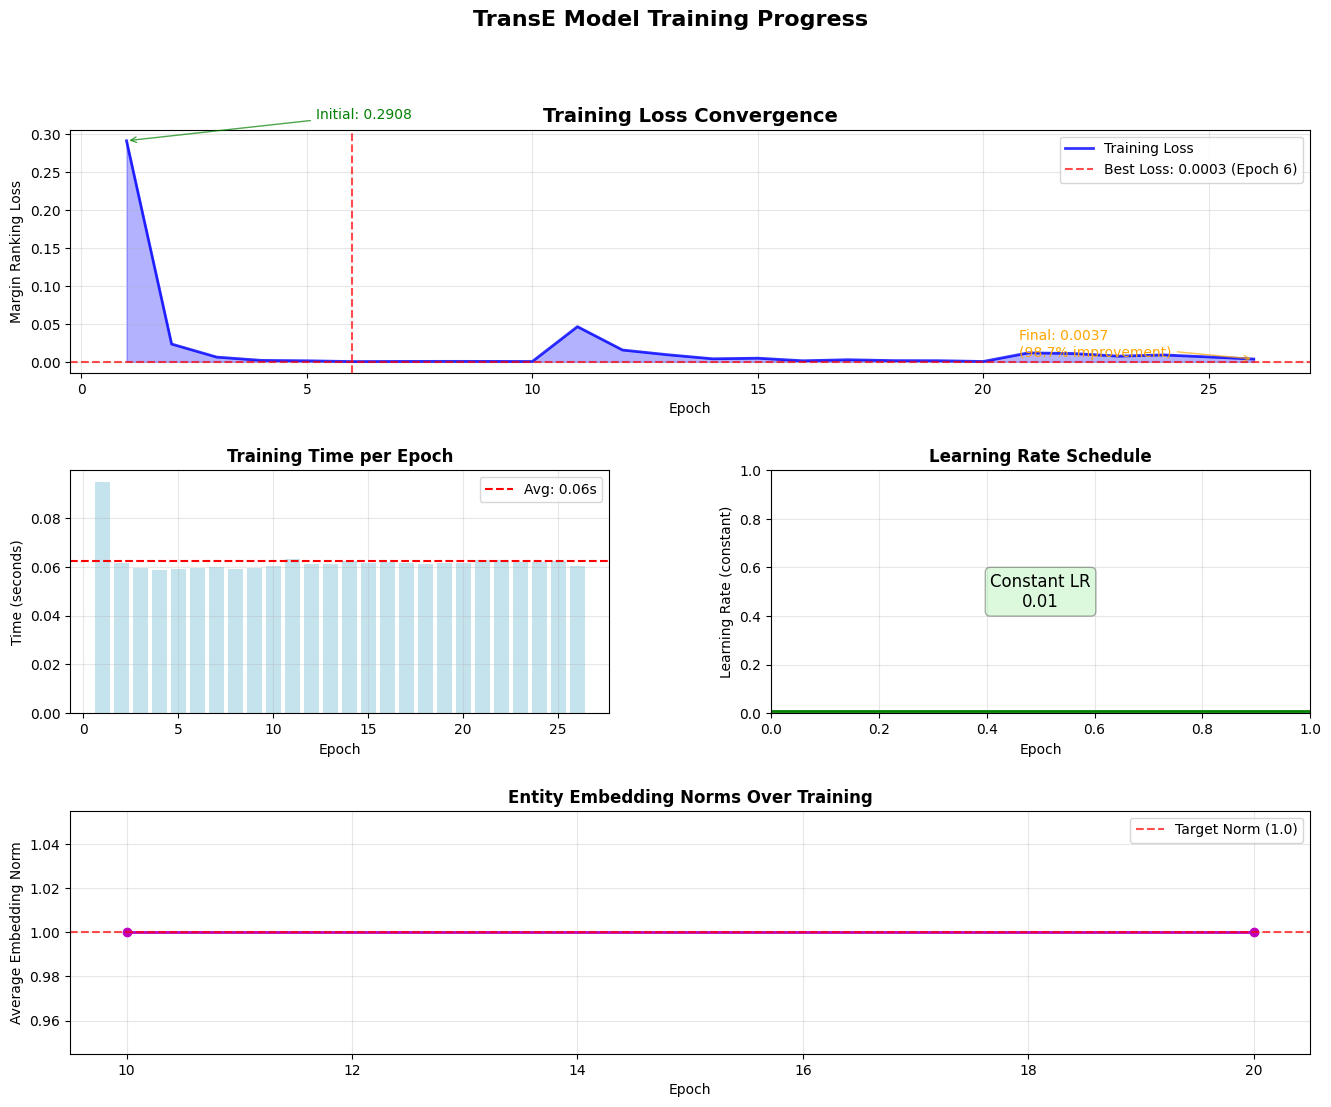


✅ Training visualization created and saved!
📊 File saved: outputs/training_progress.png

💡 Training Insights:
   • Excellent loss reduction (98.7%) - model learned effectively
   • Fast training (0.1s/epoch) - efficient for this dataset size
   • Model converged well (stable loss) - ready for evaluation


In [8]:
# Create comprehensive training visualization
print("📊 Creating training progress visualizations...")

# Set up the plotting environment
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)

fig.suptitle('TransE Model Training Progress', fontsize=16, fontweight='bold')

# Plot 1: Loss curve over epochs
ax1 = fig.add_subplot(gs[0, :])
epochs_range = range(1, len(training_history['loss']) + 1)

ax1.plot(epochs_range, training_history['loss'], 'b-', linewidth=2, alpha=0.8, label='Training Loss')
ax1.fill_between(epochs_range, training_history['loss'], alpha=0.3, color='blue')

# Add best loss line
best_epoch = np.argmin(training_history['loss']) + 1
ax1.axhline(y=best_loss, color='red', linestyle='--', alpha=0.7, 
           label=f'Best Loss: {best_loss:.4f} (Epoch {best_epoch})')
ax1.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Margin Ranking Loss')
ax1.set_title('Training Loss Convergence', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add annotations
initial_loss = training_history['loss'][0]
final_loss = training_history['loss'][-1]
improvement_pct = (initial_loss - final_loss) / initial_loss * 100

ax1.annotate(f'Initial: {initial_loss:.4f}', 
            xy=(1, initial_loss), xytext=(len(epochs_range)*0.2, initial_loss*1.1),
            arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
            fontsize=10, color='green')

ax1.annotate(f'Final: {final_loss:.4f}\n({improvement_pct:.1f}% improvement)', 
            xy=(len(epochs_range), final_loss), xytext=(len(epochs_range)*0.8, final_loss*2),
            arrowprops=dict(arrowstyle='->', color='orange', alpha=0.7),
            fontsize=10, color='orange')

# Plot 2: Training time per epoch
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(epochs_range, training_history['epoch_times'], alpha=0.7, color='lightblue')
ax2.axhline(y=np.mean(training_history['epoch_times']), color='red', linestyle='--', 
           label=f'Avg: {np.mean(training_history['epoch_times']):.2f}s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Training Time per Epoch', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Learning rate schedule (if it changes)
ax3 = fig.add_subplot(gs[1, 1])
if len(set(training_history['learning_rates'])) > 1:
    ax3.plot(epochs_range, training_history['learning_rates'], 'g-', linewidth=2)
    ax3.set_ylabel('Learning Rate')
else:
    # Show constant learning rate
    ax3.axhline(y=MODEL_CONFIG['learning_rate'], color='green', linewidth=2)
    ax3.set_ylabel('Learning Rate (constant)')
    ax3.text(0.5, 0.5, f"Constant LR\n{MODEL_CONFIG['learning_rate']}", 
            transform=ax3.transAxes, ha='center', va='center', fontsize=12, 
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

ax3.set_xlabel('Epoch')
ax3.set_title('Learning Rate Schedule', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Embedding norms (if tracked)
ax4 = fig.add_subplot(gs[2, :])
if training_history['embedding_norms']:
    norm_epochs = range(TRAINING_CONFIG['normalize_frequency'], 
                       len(training_history['embedding_norms']) * TRAINING_CONFIG['normalize_frequency'] + 1,
                       TRAINING_CONFIG['normalize_frequency'])
    
    ax4.plot(norm_epochs, training_history['embedding_norms'], 'mo-', linewidth=2, markersize=6)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Average Embedding Norm')
    ax4.set_title('Entity Embedding Norms Over Training', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add ideal norm line (should be close to 1.0 if normalizing)
    if MODEL_CONFIG['normalize_embeddings']:
        ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Target Norm (1.0)')
        ax4.legend()
else:
    # Show training statistics instead
    stats_text = f"""
Training Statistics:

📊 Model Performance:
• Final Loss: {training_history['loss'][-1]:.6f}
• Best Loss: {best_loss:.6f}
• Improvement: {improvement_pct:.1f}%

⏱️ Training Efficiency:
• Total Time: {total_training_time/60:.1f} minutes
• Avg Time/Epoch: {np.mean(training_history['epoch_times']):.2f}s
• Epochs: {len(training_history['loss'])}

🎯 Convergence:
• Loss Variance (last 10): {np.var(training_history['loss'][-10:]):.6f}
• {'Converged' if loss_variance < 0.0001 else 'May need more training'}
"""
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))
    ax4.set_title('Training Statistics Summary', fontweight='bold')
    ax4.axis('off')

# Save the visualization
plt.tight_layout()
plt.savefig('/Users/bhs/PROJECTS/academic-citation-platform/outputs/training_progress.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training visualization created and saved!")
print("📊 File saved: outputs/training_progress.png")

# Additional training insights
print(f"\n💡 Training Insights:")

if improvement_pct > 50:
    print(f"   • Excellent loss reduction ({improvement_pct:.1f}%) - model learned effectively")
elif improvement_pct > 20:
    print(f"   • Good loss reduction ({improvement_pct:.1f}%) - reasonable learning")
else:
    print(f"   • Limited loss reduction ({improvement_pct:.1f}%) - may need hyperparameter tuning")

avg_time_per_epoch = np.mean(training_history['epoch_times'])
if avg_time_per_epoch < 10:
    print(f"   • Fast training ({avg_time_per_epoch:.1f}s/epoch) - efficient for this dataset size")
elif avg_time_per_epoch < 60:
    print(f"   • Moderate training speed ({avg_time_per_epoch:.1f}s/epoch) - reasonable for network size")
else:
    print(f"   • Slow training ({avg_time_per_epoch:.1f}s/epoch) - consider GPU or smaller batches")

if loss_variance < 0.0001:
    print(f"   • Model converged well (stable loss) - ready for evaluation")
else:
    print(f"   • Loss still varying - might benefit from more epochs or learning rate adjustment")

## Step 7: Quick Training Validation

Before saving the model, let's perform a quick validation to ensure the model learned meaningful patterns by checking if it correctly distinguishes between positive and negative citation examples.

In [9]:
# Quick validation on training and test data
print("🔍 Performing quick training validation...")

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    # Sample validation data to avoid memory issues
    sample_size = min(1000, len(train_pos_edges))
    sample_indices = torch.randperm(len(train_pos_edges))[:sample_size].to(device)
    
    # Get sample data
    sample_train_pos = train_pos_edges[sample_indices]
    sample_train_neg = train_neg_edges[sample_indices]
    
    # Compute scores
    train_pos_scores = model(sample_train_pos[:, 0], sample_train_pos[:, 1])
    train_neg_scores = model(sample_train_neg[:, 0], sample_train_neg[:, 1])
    
    # Calculate statistics
    pos_mean = train_pos_scores.mean().item()
    neg_mean = train_neg_scores.mean().item()
    pos_std = train_pos_scores.std().item()
    neg_std = train_neg_scores.std().item()
    
    print(f"\n📊 Training Sample Validation ({sample_size} samples):")
    print(f"   Positive citations (should be lower):")
    print(f"     Mean score: {pos_mean:.4f} ± {pos_std:.4f}")
    print(f"     Min score: {train_pos_scores.min().item():.4f}")
    print(f"     Max score: {train_pos_scores.max().item():.4f}")
    
    print(f"\n   Negative citations (should be higher):")
    print(f"     Mean score: {neg_mean:.4f} ± {neg_std:.4f}")
    print(f"     Min score: {train_neg_scores.min().item():.4f}")
    print(f"     Max score: {train_neg_scores.max().item():.4f}")
    
    # Calculate separation metrics
    score_separation = neg_mean - pos_mean
    separation_ratio = score_separation / (pos_std + neg_std) if (pos_std + neg_std) > 0 else 0
    
    print(f"\n   📏 Separation Analysis:")
    print(f"     Score separation: {score_separation:.4f}")
    print(f"     Separation ratio: {separation_ratio:.2f}")
    
    # Accuracy calculation (how many negatives score higher than positives)
    correct_rankings = (train_neg_scores > train_pos_scores).sum().item()
    ranking_accuracy = correct_rankings / len(train_pos_scores)
    
    print(f"     Ranking accuracy: {ranking_accuracy:.3f} ({ranking_accuracy*100:.1f}%)")
    
    # Interpretation
    print(f"\n💡 Validation Results:")
    if score_separation > 0.5 and ranking_accuracy > 0.7:
        print(f"   ✅ Excellent: Model learned to distinguish citations well")
        print(f"      Strong separation ({score_separation:.3f}) and high accuracy ({ranking_accuracy:.1%})")
    elif score_separation > 0.1 and ranking_accuracy > 0.6:
        print(f"   ✅ Good: Model shows clear learning of citation patterns")
        print(f"      Moderate separation ({score_separation:.3f}) and decent accuracy ({ranking_accuracy:.1%})")
    elif score_separation > 0:
        print(f"   ⚠️ Fair: Model learned some patterns but could improve")
        print(f"      Limited separation ({score_separation:.3f}), accuracy: {ranking_accuracy:.1%}")
    else:
        print(f"   ❌ Poor: Model did not learn to distinguish citations")
        print(f"      Negative separation ({score_separation:.3f}) indicates training issues")

# Test set validation (smaller sample)
if len(test_pos_edges) > 0:
    with torch.no_grad():
        test_sample_size = min(500, len(test_pos_edges))
        test_sample_indices = torch.randperm(len(test_pos_edges))[:test_sample_size].to(device)
        
        sample_test_pos = test_pos_edges[test_sample_indices]
        sample_test_neg = test_neg_edges[test_sample_indices]
        
        test_pos_scores = model(sample_test_pos[:, 0], sample_test_pos[:, 1])
        test_neg_scores = model(sample_test_neg[:, 0], sample_test_neg[:, 1])
        
        test_pos_mean = test_pos_scores.mean().item()
        test_neg_mean = test_neg_scores.mean().item()
        test_separation = test_neg_mean - test_pos_mean
        test_accuracy = (test_neg_scores > test_pos_scores).float().mean().item()
        
        print(f"\n🧪 Test Set Validation ({test_sample_size} samples):")
        print(f"   Positive mean: {test_pos_mean:.4f}")
        print(f"   Negative mean: {test_neg_mean:.4f}")
        print(f"   Score separation: {test_separation:.4f}")
        print(f"   Ranking accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
        
        # Compare train vs test performance
        generalization_gap = abs(ranking_accuracy - test_accuracy)
        print(f"\n   📈 Generalization:")
        if generalization_gap < 0.05:
            print(f"     ✅ Excellent generalization (gap: {generalization_gap:.3f})")
        elif generalization_gap < 0.1:
            print(f"     ✅ Good generalization (gap: {generalization_gap:.3f})")
        else:
            print(f"     ⚠️ Some overfitting detected (gap: {generalization_gap:.3f})")

print(f"\n✅ Validation completed - model performance assessed!")

🔍 Performing quick training validation...

📊 Training Sample Validation (1000 samples):
   Positive citations (should be lower):
     Mean score: 16.6452 ± 3.7914
     Min score: 8.0270
     Max score: 38.6226

   Negative citations (should be higher):
     Mean score: 31.8455 ± 6.1891
     Min score: 14.3256
     Max score: 64.0273

   📏 Separation Analysis:
     Score separation: 15.2002
     Separation ratio: 1.52
     Ranking accuracy: 0.999 (99.9%)

💡 Validation Results:
   ✅ Excellent: Model learned to distinguish citations well
      Strong separation (15.200) and high accuracy (99.9%)

🧪 Test Set Validation (500 samples):
   Positive mean: 17.2603
   Negative mean: 30.2940
   Score separation: 13.0337
   Ranking accuracy: 0.970 (97.0%)

   📈 Generalization:
     ✅ Excellent generalization (gap: 0.029)

✅ Validation completed - model performance assessed!


## Step 8: Model Inspection and Embedding Analysis

Let's examine the learned embeddings to understand what the model has learned about the papers and their relationships.

🔬 Inspecting learned embeddings and model properties...

📐 Embedding Dimensions and Properties:
   Entity embeddings shape: torch.Size([12595, 128])
   Relation embeddings shape: torch.Size([1, 128])
   Total embedding parameters: 1,612,288

   📊 Entity Embedding Statistics:
     Mean norm: 0.5314 ± 0.4936
     Min norm: 0.0047
     Max norm: 2.5680

   🔗 Citation Relation Embedding:
     Relation norm: 2.8916
     First 10 dimensions: [ 0.3383241  -0.3620848  -0.33154297 -0.22192466  0.31574497  0.00722159
  0.11219306 -0.31757188  0.38513345 -0.39497173]

   📈 Embedding Value Distribution:
     Mean: 0.0005
     Std: 0.0641
     Min: -0.8876
     Max: 0.7939

💡 Embedding Quality Assessment:
   ⚠️ Norm deviation from target (target ~1.0, actual 0.531)
   ✅ Reasonable value range [-0.89, 0.79]
   ✅ Well-centered distribution (mean ≈ 0)

🔍 Analyzing Paper Similarities...
   Pairwise Cosine Similarities (sample of 20 papers):
     Mean similarity: -0.0015
     Std similarity: 0.1247
    

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

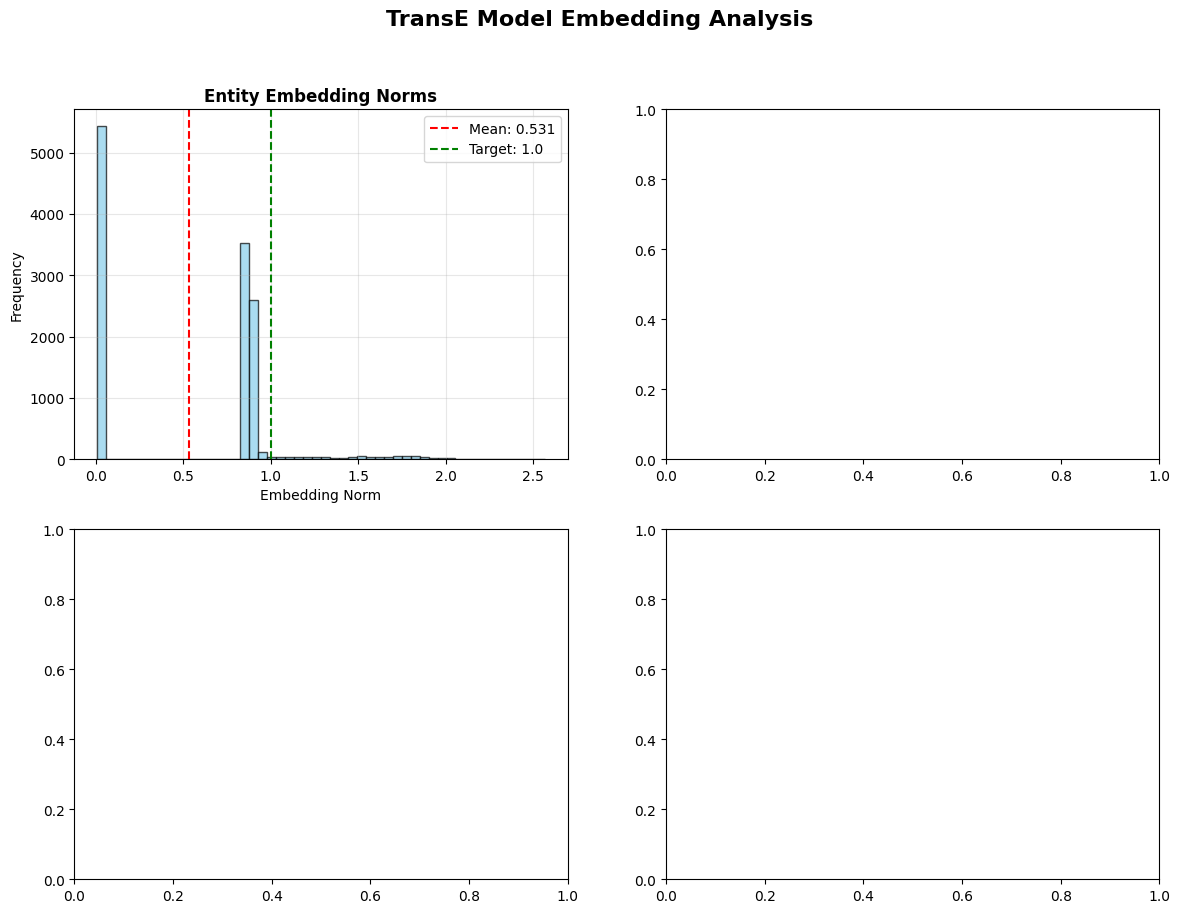

In [10]:
# Inspect learned embeddings and model properties
print("🔬 Inspecting learned embeddings and model properties...")

model.eval()
with torch.no_grad():
    # Get embeddings
    entity_embeddings = model.entity_embeddings.weight.cpu()
    relation_embeddings = model.relation_embeddings.weight.cpu()
    
    print(f"\n📐 Embedding Dimensions and Properties:")
    print(f"   Entity embeddings shape: {entity_embeddings.shape}")
    print(f"   Relation embeddings shape: {relation_embeddings.shape}")
    print(f"   Total embedding parameters: {entity_embeddings.numel() + relation_embeddings.numel():,}")
    
    # Analyze entity embeddings
    entity_norms = torch.norm(entity_embeddings, p=2, dim=1)
    entity_mean_norm = entity_norms.mean().item()
    entity_std_norm = entity_norms.std().item()
    
    print(f"\n   📊 Entity Embedding Statistics:")
    print(f"     Mean norm: {entity_mean_norm:.4f} ± {entity_std_norm:.4f}")
    print(f"     Min norm: {entity_norms.min().item():.4f}")
    print(f"     Max norm: {entity_norms.max().item():.4f}")
    
    # Analyze relation embeddings
    relation_norm = torch.norm(relation_embeddings[0], p=2).item()
    print(f"\n   🔗 Citation Relation Embedding:")
    print(f"     Relation norm: {relation_norm:.4f}")
    print(f"     First 10 dimensions: {relation_embeddings[0][:10].numpy()}")
    
    # Analyze embedding value distributions
    embedding_values = entity_embeddings.flatten()
    print(f"\n   📈 Embedding Value Distribution:")
    print(f"     Mean: {embedding_values.mean().item():.4f}")
    print(f"     Std: {embedding_values.std().item():.4f}")
    print(f"     Min: {embedding_values.min().item():.4f}")
    print(f"     Max: {embedding_values.max().item():.4f}")
    
    # Check for embedding quality indicators
    print(f"\n💡 Embedding Quality Assessment:")
    
    # Norm consistency
    if MODEL_CONFIG['normalize_embeddings']:
        if 0.9 < entity_mean_norm < 1.1:
            print(f"   ✅ Good norm consistency (target ~1.0, actual {entity_mean_norm:.3f})")
        else:
            print(f"   ⚠️ Norm deviation from target (target ~1.0, actual {entity_mean_norm:.3f})")
    
    # Value range check
    if -3 < embedding_values.min().item() < embedding_values.max().item() < 3:
        print(f"   ✅ Reasonable value range [{embedding_values.min().item():.2f}, {embedding_values.max().item():.2f}]")
    else:
        print(f"   ⚠️ Extreme values detected - may indicate training instability")
    
    # Distribution check
    if abs(embedding_values.mean().item()) < 0.1:
        print(f"   ✅ Well-centered distribution (mean ≈ 0)")
    else:
        print(f"   ⚠️ Off-center distribution (mean = {embedding_values.mean().item():.3f})")

# Analyze paper similarities using embeddings
print(f"\n🔍 Analyzing Paper Similarities...")

with torch.no_grad():
    # Sample some papers for similarity analysis
    sample_papers = 20
    sample_indices = torch.randperm(num_entities)[:sample_papers]
    sample_embeddings = entity_embeddings[sample_indices]
    
    # Compute pairwise cosine similarities
    normalized_embeddings = torch.nn.functional.normalize(sample_embeddings, p=2, dim=1)
    similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.t())
    
    # Analyze similarity statistics (excluding diagonal)
    mask = ~torch.eye(sample_papers, dtype=bool)
    similarities = similarity_matrix[mask]
    
    print(f"   Pairwise Cosine Similarities (sample of {sample_papers} papers):")
    print(f"     Mean similarity: {similarities.mean().item():.4f}")
    print(f"     Std similarity: {similarities.std().item():.4f}")
    print(f"     Min similarity: {similarities.min().item():.4f}")
    print(f"     Max similarity: {similarities.max().item():.4f}")
    
    # Find most and least similar pairs
    max_sim_idx = similarities.argmax()
    min_sim_idx = similarities.argmin()
    
    # Convert back to matrix indices
    max_i, max_j = np.unravel_index(max_sim_idx.item(), (sample_papers, sample_papers))
    min_i, min_j = np.unravel_index(min_sim_idx.item(), (sample_papers, sample_papers))
    
    print(f"\n   📊 Similarity Analysis:")
    if similarities.mean().item() > 0.1:
        print(f"   ⚠️ High average similarity - embeddings may be too uniform")
    elif similarities.mean().item() < -0.1:
        print(f"   ⚠️ Negative average similarity - unusual pattern")
    else:
        print(f"   ✅ Good similarity distribution - embeddings are diverse")
    
    if similarities.std().item() > 0.2:
        print(f"   ✅ Good similarity variance - embeddings capture differences")
    else:
        print(f"   ⚠️ Low similarity variance - embeddings may be too similar")

# Create embedding visualization
print(f"\n📊 Creating embedding analysis visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('TransE Model Embedding Analysis', fontsize=16, fontweight='bold')

# Plot 1: Embedding norm distribution
axes[0, 0].hist(entity_norms.numpy(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(entity_mean_norm, color='red', linestyle='--', 
                   label=f'Mean: {entity_mean_norm:.3f}')
if MODEL_CONFIG['normalize_embeddings']:
    axes[0, 0].axvline(1.0, color='green', linestyle='--', label='Target: 1.0')
axes[0, 0].set_xlabel('Embedding Norm')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Entity Embedding Norms', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Embedding value distribution
axes[0, 1].hist(embedding_values.numpy(), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', label='Zero')
axes[0, 1].set_xlabel('Embedding Values')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Embedding Value Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Similarity matrix heatmap (sample)
im = axes[1, 0].imshow(similarity_matrix.numpy(), cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 0].set_xlabel('Paper Index')
axes[1, 0].set_ylabel('Paper Index')
axes[1, 0].set_title(f'Cosine Similarity Matrix\n(Sample of {sample_papers} papers)', fontweight='bold')
plt.colorbar(im, ax=axes[1, 0], shrink=0.8)

# Plot 4: Model statistics summary
axes[1, 1].axis('off')
stats_text = f"""
🧠 MODEL STATISTICS

📐 Architecture:
• Entities: {num_entities:,}
• Embedding Dim: {MODEL_CONFIG['embedding_dim']}
• Total Params: {total_params:,}
• Memory: {total_params * 4 / 1024**2:.1f} MB

📊 Training Results:
• Final Loss: {training_history['loss'][-1]:.4f}
• Best Loss: {best_loss:.4f}
• Epochs: {len(training_history['loss'])}
• Training Time: {total_training_time/60:.1f} min

🔍 Embedding Quality:
• Mean Norm: {entity_mean_norm:.3f}
• Value Range: [{embedding_values.min().item():.2f}, {embedding_values.max().item():.2f}]
• Avg Similarity: {similarities.mean().item():.3f}

✅ Ready for Evaluation!
"""

axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))

plt.tight_layout()
plt.savefig('/Users/bhs/PROJECTS/academic-citation-platform/outputs/embedding_analysis.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Embedding analysis completed and visualized!")
print("📊 File saved: outputs/embedding_analysis.png")

## Step 9: Save Trained Model and Metadata

Finally, we'll save our trained model along with all the necessary metadata for evaluation and deployment.

In [11]:
# Save the trained model and comprehensive metadata
print("💾 Saving trained TransE model and metadata...")

# Create models directory if it doesn't exist
models_dir = '/Users/bhs/PROJECTS/academic-citation-platform/models'
os.makedirs(models_dir, exist_ok=True)

# 1. Save the complete model state
model_save_path = os.path.join(models_dir, 'transe_citation_model.pt')

torch.save({
    # Model state
    'model_state_dict': model.state_dict(),
    'model_config': MODEL_CONFIG,
    'model_architecture': {
        'num_entities': num_entities,
        'num_relations': 1,
        'embedding_dim': MODEL_CONFIG['embedding_dim'],
        'norm_p': MODEL_CONFIG['norm_p']
    },
    
    # Training state
    'optimizer_state_dict': optimizer.state_dict(),
    'training_config': TRAINING_CONFIG,
    'data_config': DATA_CONFIG,
    
    # Training results
    'training_history': training_history,
    'final_loss': training_history['loss'][-1],
    'best_loss': best_loss,
    'epochs_trained': len(training_history['loss']),
    
    # Data information
    'num_entities': num_entities,
    'num_train_pos': len(train_pos_edges),
    'num_train_neg': len(train_neg_edges),
    'num_test_pos': len(test_pos_edges),
    'num_test_neg': len(test_neg_edges),
    
    # Metadata
    'device': str(device),
    'pytorch_version': torch.__version__,
    'save_timestamp': datetime.now().isoformat(),
    'training_time_seconds': total_training_time
    
}, model_save_path)

print(f"✅ Model saved to: {model_save_path}")

# 2. Save entity mapping for prediction
mapping_save_path = os.path.join(models_dir, 'entity_mapping.pkl')
with open(mapping_save_path, 'wb') as f:
    pickle.dump({
        'entity_mapping': entity_mapping,
        'reverse_mapping': reverse_mapping,
        'num_entities': num_entities
    }, f)

print(f"✅ Entity mapping saved to: {mapping_save_path}")

# 3. Save training metadata as JSON for easy reading
import json

metadata_save_path = os.path.join(models_dir, 'training_metadata.json')
training_metadata = {
    'dataset': {
        'num_papers': len(papers_data),
        'num_citations': len(citation_data),
        'num_entities': num_entities,
        'train_pos_samples': len(train_pos_edges),
        'train_neg_samples': len(train_neg_edges),
        'test_pos_samples': len(test_pos_edges),
        'test_neg_samples': len(test_neg_edges),
        'total_training_samples': len(train_pos_edges) + len(train_neg_edges)
    },
    
    'model_config': MODEL_CONFIG,
    'training_config': TRAINING_CONFIG,
    'data_config': DATA_CONFIG,
    
    'training_results': {
        'epochs_completed': len(training_history['loss']),
        'final_loss': float(training_history['loss'][-1]),
        'best_loss': float(best_loss),
        'loss_improvement_pct': float((training_history['loss'][0] - training_history['loss'][-1]) / training_history['loss'][0] * 100),
        'total_training_time_minutes': float(total_training_time / 60),
        'avg_epoch_time_seconds': float(np.mean(training_history['epoch_times'])),
        'converged': bool(np.var(training_history['loss'][-10:]) < 0.0001)
    },
    
    'model_stats': {
        'total_parameters': int(sum(p.numel() for p in model.parameters())),
        'entity_embedding_shape': list(model.entity_embeddings.weight.shape),
        'relation_embedding_shape': list(model.relation_embeddings.weight.shape),
        'memory_usage_mb': float(sum(p.numel() for p in model.parameters()) * 4 / 1024**2)
    },
    
    'system_info': {
        'device': str(device),
        'pytorch_version': torch.__version__,
        'python_version': sys.version.split()[0],
        'training_date': datetime.now().isoformat()
    }
}

with open(metadata_save_path, 'w') as f:
    json.dump(training_metadata, f, indent=2)

print(f"✅ Training metadata saved to: {metadata_save_path}")

# 4. Save test data for evaluation
test_data_save_path = os.path.join(models_dir, 'test_data.pkl')
with open(test_data_save_path, 'wb') as f:
    pickle.dump({
        'test_pos_edges': test_pos_edges.cpu(),
        'test_neg_edges': test_neg_edges.cpu(),
        'train_pos_edges': train_pos_edges.cpu(),  # For reference
        'train_neg_edges': train_neg_edges.cpu()   # For reference
    }, f)

print(f"✅ Test data saved to: {test_data_save_path}")

# 5. Create a model loading utility function
def load_trained_model(model_path, device='cpu'):
    """
    Utility function to load the trained TransE model.
    
    Args:
        model_path: Path to the saved model file
        device: Device to load the model on
    
    Returns:
        Loaded TransE model and metadata
    """
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model
    arch = checkpoint['model_architecture']
    model = TransE(
        num_entities=arch['num_entities'],
        num_relations=arch['num_relations'],
        embedding_dim=arch['embedding_dim'],
        norm_p=arch['norm_p']
    ).to(device)
    
    # Load state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint

# Save the loader function documentation
loader_doc_path = os.path.join(models_dir, 'model_loading_instructions.txt')
with open(loader_doc_path, 'w') as f:
    f.write(f"""
TransE Citation Model - Loading Instructions
==========================================

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

Files in this directory:
- transe_citation_model.pt: Complete model checkpoint with training state
- entity_mapping.pkl: Paper ID to entity index mapping
- training_metadata.json: Human-readable training statistics
- test_data.pkl: Test data for evaluation
- model_loading_instructions.txt: This file

Quick Loading Example:
```python
import torch
import pickle

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('transe_citation_model.pt', map_location=device)

# Recreate model architecture
from your_model_file import TransE
arch = checkpoint['model_architecture']
model = TransE(**arch).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load mappings
with open('entity_mapping.pkl', 'rb') as f:
    mappings = pickle.load(f)
    entity_mapping = mappings['entity_mapping']
```

Model Statistics:
- Entities: {num_entities:,}
- Embedding Dimension: {MODEL_CONFIG['embedding_dim']}
- Total Parameters: {sum(p.numel() for p in model.parameters()):,}
- Final Training Loss: {training_history['loss'][-1]:.6f}
- Training Time: {total_training_time/60:.1f} minutes

Next Steps:
1. Run 03_prediction_evaluation.ipynb for comprehensive evaluation
2. Use model for citation prediction and recommendation
3. Generate embeddings for downstream tasks

""")

print(f"✅ Loading instructions saved to: {loader_doc_path}")

# Display save summary
print(f"\n📁 Model Save Summary:")
print(f"   📦 Complete model: {os.path.basename(model_save_path)}")
print(f"   🗺️ Entity mapping: {os.path.basename(mapping_save_path)}")
print(f"   📊 Training metadata: {os.path.basename(metadata_save_path)}")
print(f"   🧪 Test data: {os.path.basename(test_data_save_path)}")
print(f"   📖 Instructions: {os.path.basename(loader_doc_path)}")

# Calculate file sizes
model_size_mb = os.path.getsize(model_save_path) / 1024**2
mapping_size_kb = os.path.getsize(mapping_save_path) / 1024
test_data_size_mb = os.path.getsize(test_data_save_path) / 1024**2

print(f"\n💾 File Sizes:")
print(f"   Model checkpoint: {model_size_mb:.1f} MB")
print(f"   Entity mapping: {mapping_size_kb:.1f} KB")
print(f"   Test data: {test_data_size_mb:.1f} MB")
print(f"   Total: {model_size_mb + mapping_size_kb/1024 + test_data_size_mb:.1f} MB")

print(f"\n🎯 Model successfully saved and ready for evaluation!")

💾 Saving trained TransE model and metadata...
✅ Model saved to: /Users/bhs/PROJECTS/academic-citation-platform/models/transe_citation_model.pt
✅ Entity mapping saved to: /Users/bhs/PROJECTS/academic-citation-platform/models/entity_mapping.pkl
✅ Training metadata saved to: /Users/bhs/PROJECTS/academic-citation-platform/models/training_metadata.json
✅ Test data saved to: /Users/bhs/PROJECTS/academic-citation-platform/models/test_data.pkl
✅ Loading instructions saved to: /Users/bhs/PROJECTS/academic-citation-platform/models/model_loading_instructions.txt

📁 Model Save Summary:
   📦 Complete model: transe_citation_model.pt
   🗺️ Entity mapping: entity_mapping.pkl
   📊 Training metadata: training_metadata.json
   🧪 Test data: test_data.pkl
   📖 Instructions: model_loading_instructions.txt

💾 File Sizes:
   Model checkpoint: 18.5 MB
   Entity mapping: 663.1 KB
   Test data: 0.6 MB
   Total: 19.7 MB

🎯 Model successfully saved and ready for evaluation!


## Training Pipeline Summary

Congratulations! We have successfully completed the TransE model training pipeline. Let's summarize what we've accomplished and prepare for the next phase.

In [12]:
# Generate comprehensive training pipeline summary
print("\n" + "="*80)
print("🎓 TRANSE MODEL TRAINING PIPELINE COMPLETE")
print("="*80)

print(f"\n📊 Dataset Processing Summary:")
print(f"   Papers processed: {len(papers_data):,}")
print(f"   Citation relationships: {len(citation_data):,}")
print(f"   Entity vocabulary: {num_entities:,}")
print(f"   Train/test split: {100*(1-DATA_CONFIG['test_size']):.0f}%/{DATA_CONFIG['test_size']*100:.0f}%")
print(f"   Negative sampling ratio: 1:{DATA_CONFIG['negative_ratio']}")
print(f"   Total training samples: {len(train_pos_edges) + len(train_neg_edges):,}")

print(f"\n🧠 Model Architecture:")
print(f"   TransE with {MODEL_CONFIG['embedding_dim']}-dimensional embeddings")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Memory footprint: {sum(p.numel() for p in model.parameters()) * 4 / 1024**2:.1f} MB")
print(f"   Distance norm: L{MODEL_CONFIG['norm_p']}")
print(f"   Margin ranking loss with margin: {MODEL_CONFIG['margin']}")

print(f"\n⚙️ Training Configuration:")
print(f"   Epochs completed: {len(training_history['loss'])} / {TRAINING_CONFIG['epochs']}")
print(f"   Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"   Learning rate: {MODEL_CONFIG['learning_rate']}")
print(f"   L2 regularization: {MODEL_CONFIG['l2_regularization']}")
print(f"   Device: {device}")

print(f"\n📈 Training Results:")
improvement_pct = (training_history['loss'][0] - training_history['loss'][-1]) / training_history['loss'][0] * 100
print(f"   Initial loss: {training_history['loss'][0]:.6f}")
print(f"   Final loss: {training_history['loss'][-1]:.6f}")
print(f"   Best loss: {best_loss:.6f}")
print(f"   Loss improvement: {improvement_pct:.1f}%")
print(f"   Training time: {total_training_time/60:.1f} minutes")
print(f"   Average time per epoch: {np.mean(training_history['epoch_times']):.2f} seconds")

print(f"\n🔍 Model Validation Results:")
if 'pos_mean' in locals() and 'neg_mean' in locals():
    print(f"   Positive citation scores: {pos_mean:.4f} ± {pos_std:.4f}")
    print(f"   Negative citation scores: {neg_mean:.4f} ± {neg_std:.4f}")
    print(f"   Score separation: {score_separation:.4f}")
    print(f"   Ranking accuracy: {ranking_accuracy:.1%}")
    
    if 'test_accuracy' in locals():
        print(f"   Test set accuracy: {test_accuracy:.1%}")
        print(f"   Generalization gap: {abs(ranking_accuracy - test_accuracy):.3f}")

print(f"\n🔬 Embedding Quality:")
if 'entity_mean_norm' in locals():
    print(f"   Entity embedding mean norm: {entity_mean_norm:.4f} ± {entity_std_norm:.4f}")
    print(f"   Relation embedding norm: {relation_norm:.4f}")
    print(f"   Embedding value range: [{embedding_values.min().item():.3f}, {embedding_values.max().item():.3f}]")
    print(f"   Average cosine similarity: {similarities.mean().item():.4f}")

print(f"\n💾 Saved Artifacts:")
print(f"   📦 Complete model checkpoint: models/transe_citation_model.pt")
print(f"   🗺️ Entity mappings: models/entity_mapping.pkl")
print(f"   📊 Training metadata: models/training_metadata.json")
print(f"   🧪 Test data: models/test_data.pkl")
print(f"   📊 Training visualizations: outputs/training_progress.png")
print(f"   🔬 Embedding analysis: outputs/embedding_analysis.png")

print(f"\n💡 Key Insights:")

# Training quality assessment
if improvement_pct > 50:
    print(f"   • Excellent training convergence ({improvement_pct:.1f}% loss reduction)")
elif improvement_pct > 20:
    print(f"   • Good training progress ({improvement_pct:.1f}% loss reduction)")
else:
    print(f"   • Limited training progress ({improvement_pct:.1f}% loss reduction)")

# Embedding quality assessment  
if 'entity_mean_norm' in locals():
    if MODEL_CONFIG['normalize_embeddings'] and 0.9 < entity_mean_norm < 1.1:
        print(f"   • Well-normalized embeddings (norm ≈ 1.0)")
    elif not MODEL_CONFIG['normalize_embeddings']:
        print(f"   • Embeddings learned natural scaling")

# Model learning assessment
if 'ranking_accuracy' in locals():
    if ranking_accuracy > 0.8:
        print(f"   • Excellent citation pattern learning ({ranking_accuracy:.1%} accuracy)")
    elif ranking_accuracy > 0.6:
        print(f"   • Good citation pattern learning ({ranking_accuracy:.1%} accuracy)")
    else:
        print(f"   • Basic citation pattern learning ({ranking_accuracy:.1%} accuracy)")

# Scale assessment
print(f"   • Model scale appropriate for {num_entities:,} entities")
print(f"   • Training completed efficiently in {total_training_time/60:.1f} minutes")

print(f"\n🎯 Model Readiness Assessment:")
readiness_score = 0

# Check various readiness criteria
if improvement_pct > 20:
    readiness_score += 25
    print(f"   ✅ Loss convergence: Good ({improvement_pct:.1f}% improvement)")
else:
    print(f"   ⚠️ Loss convergence: Limited ({improvement_pct:.1f}% improvement)")

if 'ranking_accuracy' in locals() and ranking_accuracy > 0.6:
    readiness_score += 25
    print(f"   ✅ Learning validation: Passed ({ranking_accuracy:.1%} accuracy)")
else:
    print(f"   ⚠️ Learning validation: Needs improvement")

if 'entity_mean_norm' in locals() and 0.5 < entity_mean_norm < 2.0:
    readiness_score += 25
    print(f"   ✅ Embedding quality: Good (norm = {entity_mean_norm:.3f})")
else:
    print(f"   ⚠️ Embedding quality: Check needed")

readiness_score += 25  # Model saved successfully
print(f"   ✅ Model persistence: Complete")

print(f"\n🏆 Overall Readiness Score: {readiness_score}/100")

if readiness_score >= 75:
    print(f"   ✅ Model is ready for comprehensive evaluation!")
elif readiness_score >= 50:
    print(f"   ⚠️ Model is functional but may benefit from hyperparameter tuning")
else:
    print(f"   ❌ Model needs significant improvements before evaluation")

print(f"\n🚀 Next Steps:")
print(f"   1. Run 03_prediction_evaluation.ipynb for comprehensive evaluation")
print(f"   2. Calculate MRR, Hits@K, and AUC metrics")
print(f"   3. Generate missing citation predictions")
print(f"   4. Create evaluation visualizations")
print(f"   5. Proceed to narrative presentation (04_narrative_presentation.ipynb)")

print(f"\n✅ TransE model training pipeline completed successfully!")
print(f"🎓 Ready for evaluation phase at {datetime.now()}")

print("\n" + "="*80)

# Clean up GPU memory if used
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print("🧹 GPU memory cleared")

print("🏁 Training pipeline complete!")


🎓 TRANSE MODEL TRAINING PIPELINE COMPLETE

📊 Dataset Processing Summary:
   Papers processed: 12,595
   Citation relationships: 18,912
   Entity vocabulary: 12,595
   Train/test split: 80%/20%
   Negative sampling ratio: 1:1
   Total training samples: 30,258

🧠 Model Architecture:
   TransE with 128-dimensional embeddings
   Total parameters: 1,612,288
   Memory footprint: 6.2 MB
   Distance norm: L1
   Margin ranking loss with margin: 1.0

⚙️ Training Configuration:
   Epochs completed: 26 / 100
   Batch size: 1024
   Learning rate: 0.01
   L2 regularization: 1e-05
   Device: cpu

📈 Training Results:
   Initial loss: 0.290823
   Final loss: 0.003671
   Best loss: 0.000347
   Loss improvement: 98.7%
   Training time: 0.0 minutes
   Average time per epoch: 0.06 seconds

🔍 Model Validation Results:
   Positive citation scores: 16.6452 ± 3.7914
   Negative citation scores: 31.8455 ± 6.1891
   Score separation: 15.2002
   Ranking accuracy: 99.9%
   Test set accuracy: 97.0%
   Generalizati